# Water Quality Notebook

Notebook for calculation of Turbidity, via the normalised difference turbity index (NDTI)in water bodies.

Add in more context here. 





### Import required modules

In [1]:
# jupyteronly

%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as pl

In [2]:
from pyproj import Proj, transform
from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.dc_water_quality import tsm
from datacube_utilities.dc_water_classifier import wofs_classify
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


## Initialise

In [6]:
# jupyteronly
dc = datacube.Datacube(app='waterquality')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [45]:
#set baseline start and end of period
baseline_start_date = '2018-2-1'
baseline_end_date = '2018-4-30'

#resolution 
res = (10)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
#won't run for S2 - out of memory error.
platform = "SENTINEL_2"
#aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"
#aoi_wkt = "POLYGON((178.51212272613253 -18.079025694549387,178.57289085357397 -18.079025694549387,178.57289085357397 -18.15113922408976,178.51212272613253 -18.15113922408976,178.51212272613253 -18.079025694549387))"
#Sigatoka
aoi_wkt = "POLYGON((177.5029362281993 -18.156155117453817,177.53100286333114 -18.156155117453817,177.53100286333114 -18.18062057733904,177.5029362281993 -18.18062057733904,177.5029362281993 -18.156155117453817))"
#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:3460"
crs = "EPSG:3460"

#Add in index here.
#other option TSM
#index = 'ndti'

## Translate inputs

In [46]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)


In [47]:
#create resolution
resolution = (-res, res)

In [48]:
dask_chunks = dict(
    time = 10,
    x = 600,
    y = 600
)

In [49]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [50]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [51]:
# crs's for input parameters 
inProj  = Proj("+init=EPSG:4326")
#this is hard coded can it be related to crs variable above. 
outProj = Proj("+init=EPSG:3460")

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [52]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [53]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """Entry point for launching an IPython kernel.
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


In [54]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [55]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 's2_water_mlclassification'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_mlclassification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_mlclassification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_mlclassification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_mlclassification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [56]:
product, measurement, water_product = create_product_measurement(platform)

## Load Data 

In [57]:
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
    'dask_chunks': dask_chunks,
    'crs': crs
}

In [58]:
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)
ds

<xarray.Dataset>
Dimensions:               (time: 36, x: 297, y: 273)
Coordinates:
  * time                  (time) datetime64[ns] 2018-02-01T22:30:01 ... 2018-...
  * y                     (y) float64 3.872e+06 3.872e+06 ... 3.869e+06
  * x                     (x) float64 1.868e+06 1.868e+06 ... 1.871e+06
    spatial_ref           int32 3460
Data variables:
    green                 (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    red                   (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    blue                  (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    nir                   (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    swir1                 (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    swir2                 (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    coastal_aerosol       (time, y, x) uint16 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    scene_classification  (time, y, x) uint8 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [59]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


## Mask cloud

In [60]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification != 0) & # mask out NO_DATA
            (ds.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (ds.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (ds.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (ds.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (ds.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (ds.scene_classification != 10)&  # mask out THIN_CIRRUS
            (ds.scene_classification != 11)  # mask out SNOW
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [61]:
good_quality = look_up_clean(platform, ds)

In [62]:
ds_clear = ds.where(good_quality)
ds_clear

<xarray.Dataset>
Dimensions:               (time: 36, x: 297, y: 273)
Coordinates:
  * time                  (time) datetime64[ns] 2018-02-01T22:30:01 ... 2018-...
  * y                     (y) float64 3.872e+06 3.872e+06 ... 3.869e+06
  * x                     (x) float64 1.868e+06 1.868e+06 ... 1.871e+06
    spatial_ref           int32 3460
Data variables:
    green                 (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    red                   (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    blue                  (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    nir                   (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    swir1                 (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    swir2                 (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    coastal_aerosol       (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    scene_classification  (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

## Create and apply land masks
For Landsat these are pre-created. For Sentinel-2 these need to be created.

#when S2 mask is ready - can remove the if statement. 
if platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes = dc.load(product=water_product,
              measurements = ["water_classification"],
               **query)
    #change clouds to no data value
    water_classes = water_scenes.where(water_scenes >= 0)
elif platform in ["SENTINEL_2"]:
    water_classes = dask.delayed(wofs_classify)(ds, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes = water_classes.rename({'wofs': 'water_classification'})

In [63]:
#when S2 mask is ready - can remove the if statement.
if platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"]:   
    water_scenes = dc.load(product= water_product,
              measurements = ["watermask", "waterprob"],
               **query)
    #change clouds to no data value
    water_classes = water_scenes.where(water_scenes >= 0)
    good_quality_water = (
       (water_scenes.watermask >= 0) & # no data
        (
         (water_scenes.waterprob <= 5) |
            (water_scenes.waterprob >= 95)
        )
        )
    water_dataset = water_scenes.where(good_quality_water)


In [64]:
#set land to no_data
#water_dataset = water_classes.where(water_classes > 0)
#water_dataset

In [65]:
print(water_dataset)

<xarray.Dataset>
Dimensions:      (time: 29, x: 297, y: 273)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-01T22:30:01 ... 2018-04-29T22:...
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    watermask    (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
    waterprob    (time, y, x) float64 dask.array<chunksize=(10, 273, 297), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref


In [66]:
#water_dataset = water_dataset.mean()

In [67]:
#print(water_dataset)

In [68]:
%%time
#mask clear by water mask
#ds_clear_land = ds_clear.where(water_dataset.water_classification > 0)
ds_clear_land = ds_clear.where(water_dataset.watermask > 0.1)

CPU times: user 84.1 ms, sys: 5.18 ms, total: 89.3 ms
Wall time: 88 ms


In [69]:
print(ds_clear_land)

<xarray.Dataset>
Dimensions:               (time: 29, x: 297, y: 273)
Coordinates:
  * time                  (time) datetime64[ns] 2018-02-01T22:30:01 ... 2018-...
  * y                     (y) float64 3.872e+06 3.872e+06 ... 3.869e+06
  * x                     (x) float64 1.868e+06 1.868e+06 ... 1.871e+06
    spatial_ref           int32 3460
Data variables:
    green                 (time, y, x) float64 dask.array<chunksize=(8, 273, 297), meta=np.ndarray>
    red                   (time, y, x) float64 dask.array<chunksize=(8, 273, 297), meta=np.ndarray>
    blue                  (time, y, x) float64 dask.array<chunksize=(8, 273, 297), meta=np.ndarray>
    nir                   (time, y, x) float64 dask.array<chunksize=(8, 273, 297), meta=np.ndarray>
    swir1                 (time, y, x) float64 dask.array<chunksize=(8, 273, 297), meta=np.ndarray>
    swir2                 (time, y, x) float64 dask.array<chunksize=(8, 273, 297), meta=np.ndarray>
    coastal_aerosol       (time, y, x) 

In [70]:
index = 'NDTI'

In [71]:
def calNDTI(dataset_in, clean_mask=None, no_data=0):
    """
    Inputs:
        dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube.
    Optional Inputs:
        clean_mask (numpy.ndarray with dtype boolean) - true for values user considers clean;
            if user does not provide a clean mask, all values will be considered clean
        no_data (int/float) - no data pixel value; default: -9999
    Throws:
        ValueError - if dataset_in is an empty xarray.Dataset.
    """
    assert 'red' in dataset_in and 'green' in dataset_in, "Red and Green bands are required for the TSM analysis."
    # Default to masking nothing.
    if clean_mask is None:
        clean_mask = create_default_clean_mask(dataset_in)

    tsm = (dataset_in.nir - dataset_in.green)/(dataset_in.red + dataset_in.green)
    tsm.values[np.invert(clean_mask)] = no_data  # Contains data for clear pixels

    # Create xarray of data
    _coords = { key:dataset_in[key] for key in dataset_in.dims.keys()}
    dataset_out = xr.Dataset({'tsm': tsm}, coords=_coords)
    return dataset_out

In [72]:
def calNDTI(dataset):
    return (dataset.nir - dataset.green)/(dataset.red + dataset.green)

In [1]:
%%time
#create tsm
if index in ["TSM"]:
    tsm_dataset = xr.map_blocks(tsm, ds_clear_land)
    tsm_dataset = tsm_dataset.tsm
elif index in ['NDTI']:
    tsm_dataset = xr.map_blocks(calNDTI, ds_clear_land)
elif index in['CHLOROPHYLL-A']:
    if s
    print('still need to develop this')
else:
    print('invalid index')

NameError: name 'index' is not defined

In [74]:
%%time
mean_tsm = tsm_dataset.mean(dim=['time'])
max_tsm = tsm_dataset.max(dim=['time'])
min_tsm = tsm_dataset.min(dim=['time'])

CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 17.4 ms


In [75]:
#mean_tsm = dask.compute(mean_tsm)

In [76]:
%%time
mean_tsm, max_tsm, min_tsm = dask.compute(mean_tsm, max_tsm, min_tsm)
#mean_tsm = dask.compute(mean_tsm)

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1min 31s


In [77]:
print(mean_tsm)

<xarray.DataArray (y: 273, x: 297)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.44134376, -0.42119598, -0.41873188, ..., -0.44556436,
        -0.45949433, -0.44453438],
       [-0.43446794, -0.41927963, -0.40439411, ..., -0.45098322,
        -0.43846841, -0.44392209],
       [-0.41792722, -0.40702401, -0.40640687, ..., -0.42736175,
        -0.46224973, -0.4511662 ]])
Coordinates:
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460


In [78]:
print(min_tsm)

<xarray.DataArray (y: 273, x: 297)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.79710145, -0.76303318, -0.78703704, ..., -0.85714286,
        -0.85585586, -0.85897436],
       [-0.78743961, -0.80769231, -0.75700935, ..., -0.91803279,
        -0.7826087 , -0.82051282],
       [-0.7972973 , -0.73451327, -0.76497696, ..., -0.7804878 ,
        -0.97101449, -0.89552239]])
Coordinates:
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460


In [79]:
print(max_tsm)

<xarray.DataArray (y: 273, x: 297)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.2709276 , -0.26798144, -0.24611973, ..., -0.20680628,
        -0.21024259, -0.18378378],
       [-0.29451439, -0.21410579, -0.22391304, ..., -0.20430108,
        -0.16081871, -0.17816092],
       [-0.20973783, -0.23191489, -0.28014766, ..., -0.19685039,
        -0.24806202, -0.2347561 ]])
Coordinates:
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460


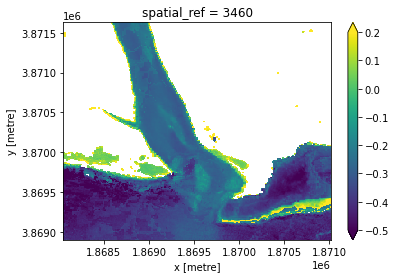

In [80]:
#fig = plt.figure(figsize=(8, 8))
mean_tsm.plot(robust=True, vmin = -0.5, vmax = 0.2)

In [81]:
write_geotiff_from_xr('mean_tsm.tiff', mean_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')


## Calculate mean, maximum and minimum TSM for the time period and export as GeoTiffs.

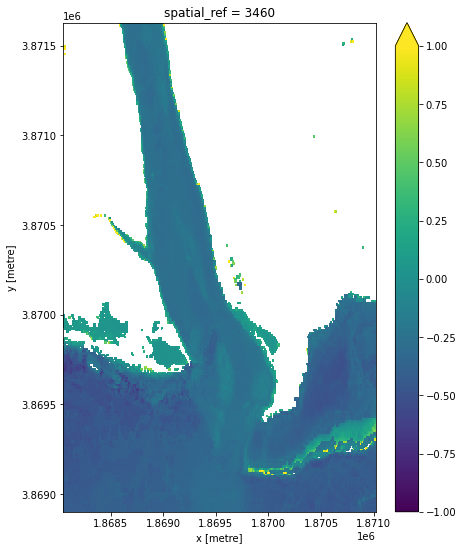

In [40]:
fig = plt.figure(figsize=(7, 9))
mean_tsm.plot(robust=True, vmin= -1, vmax = 1)

## plot max tsm

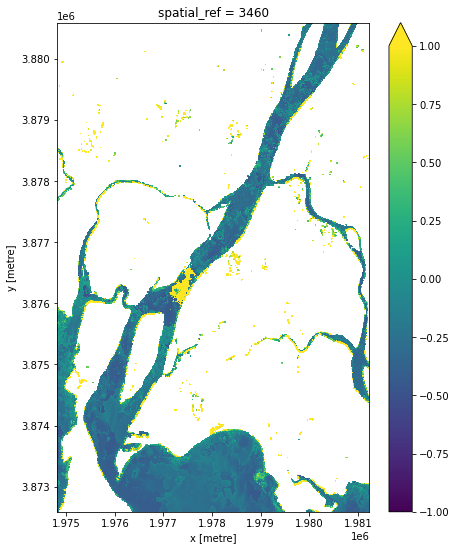

In [40]:
fig = plt.figure(figsize=(7, 9))
max_tsm.plot(robust=True, vmin = -1, vmax = 1)

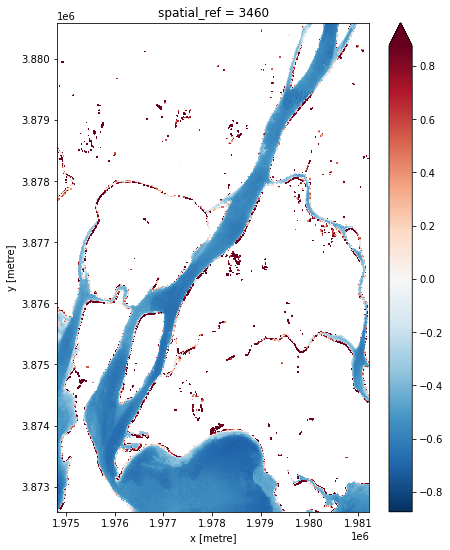

In [41]:
fig = plt.figure(figsize=(7, 9))
min_tsm.plot(robust=True)

## Exports

In [30]:
write_geotiff_from_xr('mean_tsm.tiff', mean_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('min_tsm.tiff', min_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('max_tsm.tiff', max_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')

---